In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32,
)

Found 7132 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['Peach___Bacterial_spot', 'Peach___healthy']


In [6]:
len(dataset)

223

In [7]:
# 0,1,2,3...9 classes (10 classes)
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].shape)

(32, 256, 256, 3)
[0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1]
(256, 256, 3)


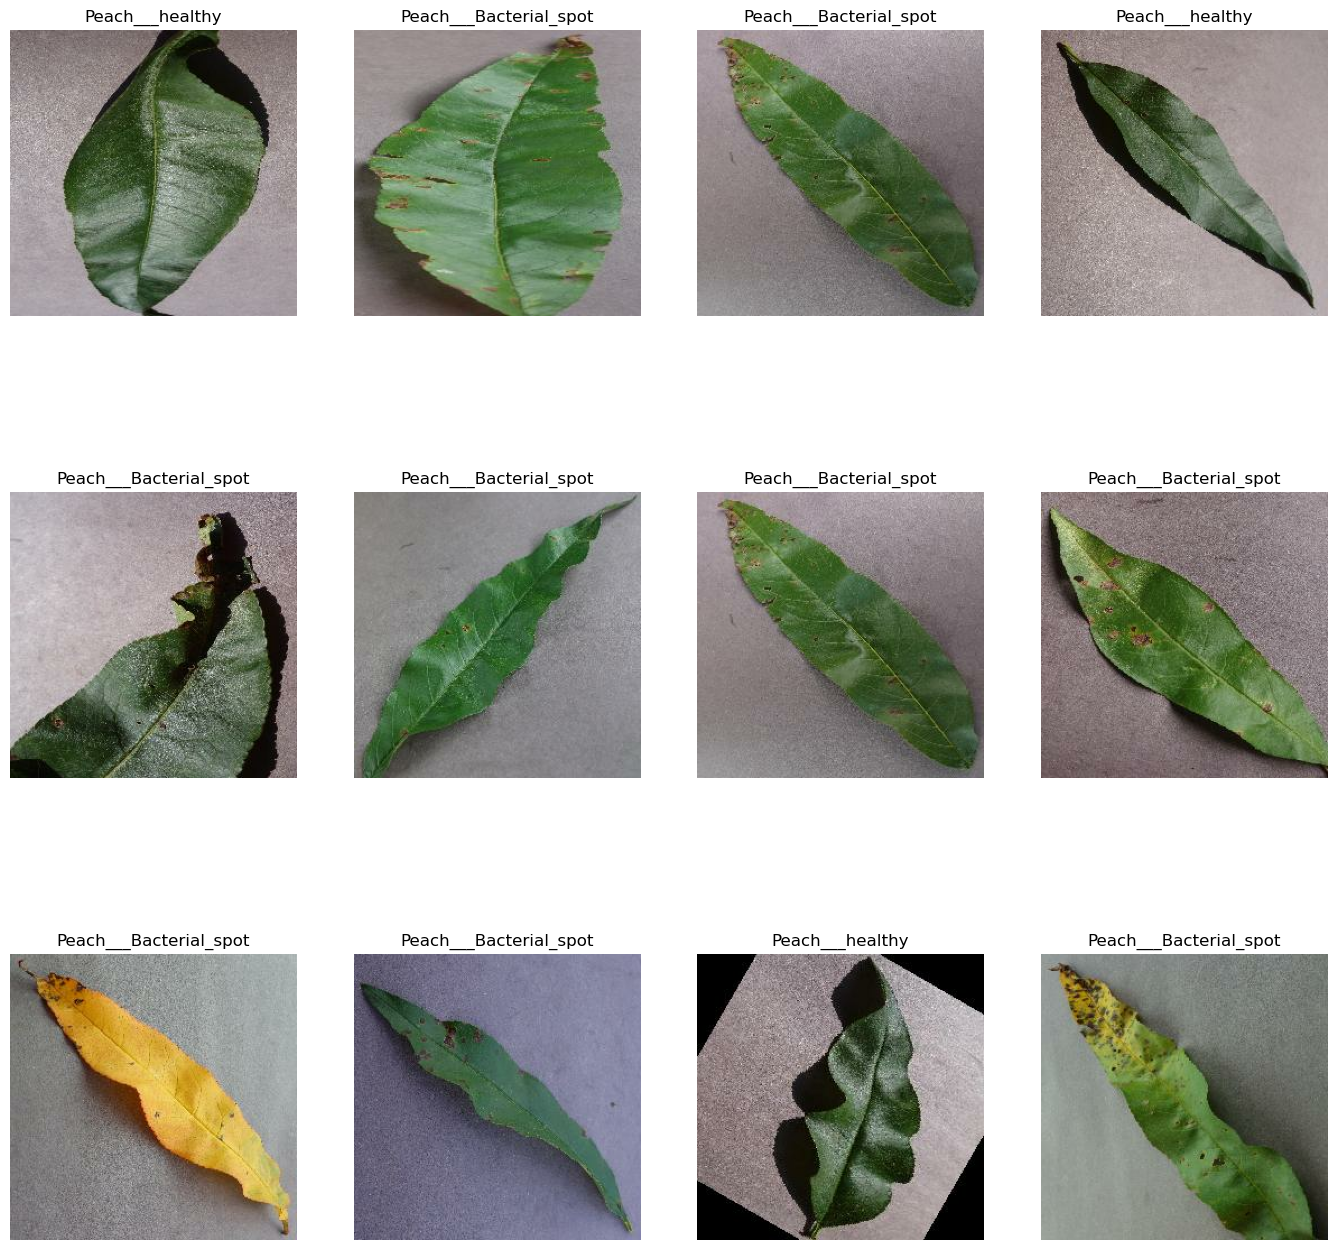

In [8]:
#visualize image
plt.figure(figsize=(17,17)) #to fix images size
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
#80% ==> training 
#20% ==> 10% validation, 10% test

In [10]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [12]:
print(len(train_ds),
len(val_ds),
len(test_ds))

178 22 23


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
input_shape = (32, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [18]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [19]:
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=50,
          batch_size=32,
          verbose=1)

Epoch 1/50
178/178 [==============================] - 59s 251ms/step - loss: 0.2467 - accuracy: 0.8898 - val_loss: 0.3546 - val_accuracy: 0.9034
Epoch 2/50
178/178 [==============================] - 24s 135ms/step - loss: 0.0954 - accuracy: 0.9687 - val_loss: 0.2772 - val_accuracy: 0.9304
Epoch 3/50
178/178 [==============================] - 20s 115ms/step - loss: 0.0834 - accuracy: 0.9700 - val_loss: 0.1560 - val_accuracy: 0.9503
Epoch 4/50
178/178 [==============================] - 20s 111ms/step - loss: 0.0746 - accuracy: 0.9752 - val_loss: 0.0982 - val_accuracy: 0.9702
Epoch 5/50
178/178 [==============================] - 19s 109ms/step - loss: 0.0582 - accuracy: 0.9787 - val_loss: 0.0611 - val_accuracy: 0.9744
Epoch 6/50
178/178 [==============================] - 19s 106ms/step - loss: 0.0709 - accuracy: 0.9777 - val_loss: 0.0806 - val_accuracy: 0.9688
Epoch 7/50
178/178 [==============================] - 18s 104ms/step - loss: 0.0400 - accuracy: 0.9858 - val_loss: 0.0501 - val_ac

In [20]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 4s 26ms/step - loss: 0.0277 - accuracy: 0.9932


In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 178}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
history.history['accuracy']

[0.8898453712463379,
 0.9687280654907227,
 0.9699578285217285,
 0.9752283692359924,
 0.9787421226501465,
 0.9776879549026489,
 0.985769510269165,
 0.9869992733001709,
 0.9877020120620728,
 0.9829585552215576,
 0.9913914203643799,
 0.9859451651573181,
 0.9894589185714722,
 0.9931482672691345,
 0.9933239817619324,
 0.98664790391922,
 0.9931482672691345,
 0.9957835674285889,
 0.9913914203643799,
 0.9966619610786438,
 0.9961349368095398,
 0.9871749877929688,
 0.9919185042381287,
 0.9949051141738892,
 0.9947294592857361,
 0.995607852935791,
 0.9975404143333435,
 0.9920941591262817,
 0.9966619610786438,
 0.9926212430000305,
 0.9984188079833984,
 0.9987701773643494,
 0.9922698736190796,
 0.9966619610786438,
 0.986120879650116,
 0.9954321980476379,
 0.9945537447929382,
 0.9977160692214966,
 0.9985945224761963,
 0.9996486306190491,
 0.9996486306190491,
 0.9903373122215271,
 0.9982431530952454,
 0.9985945224761963,
 0.9968376755714417,
 1.0,
 0.9989458918571472,
 0.9748769998550415,
 0.994729459

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

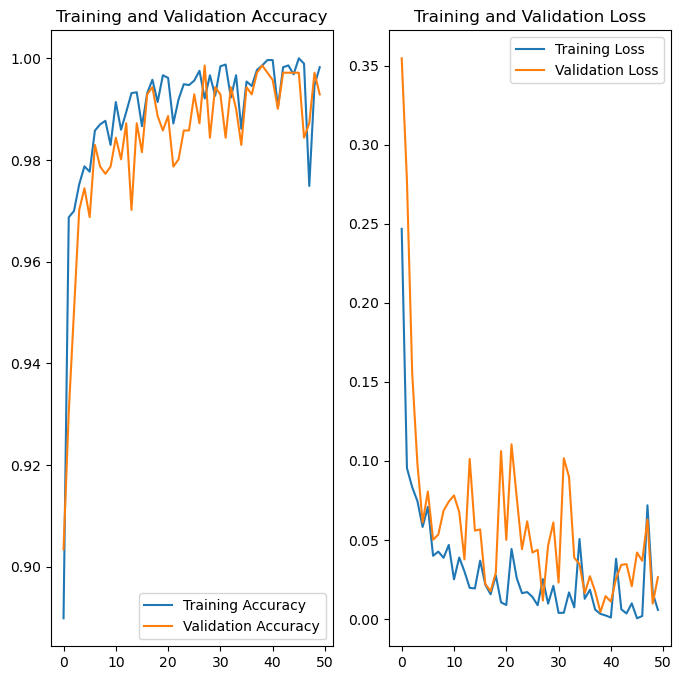

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual lable:  Peach___healthy
1/1 [==============================] - 0s 133ms/step
Predicted lable:  Peach___healthy


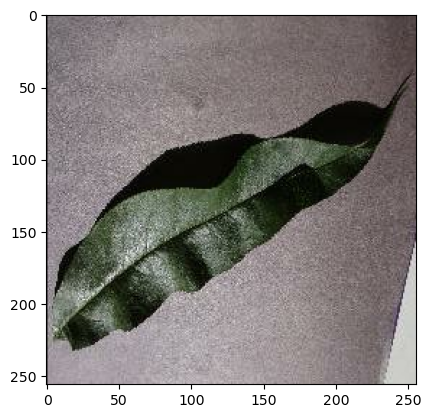

In [26]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype("uint8"))
    first_lable = label_batch[0].numpy()

    print("First image to predict")

    plt.imshow(first_image)
    print("Actual lable: ", class_names[first_lable])
    #print(class_names[first_lable])

    batch_prediction = model.predict(image_batch)
    print("Predicted lable: ", class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 4ms/step


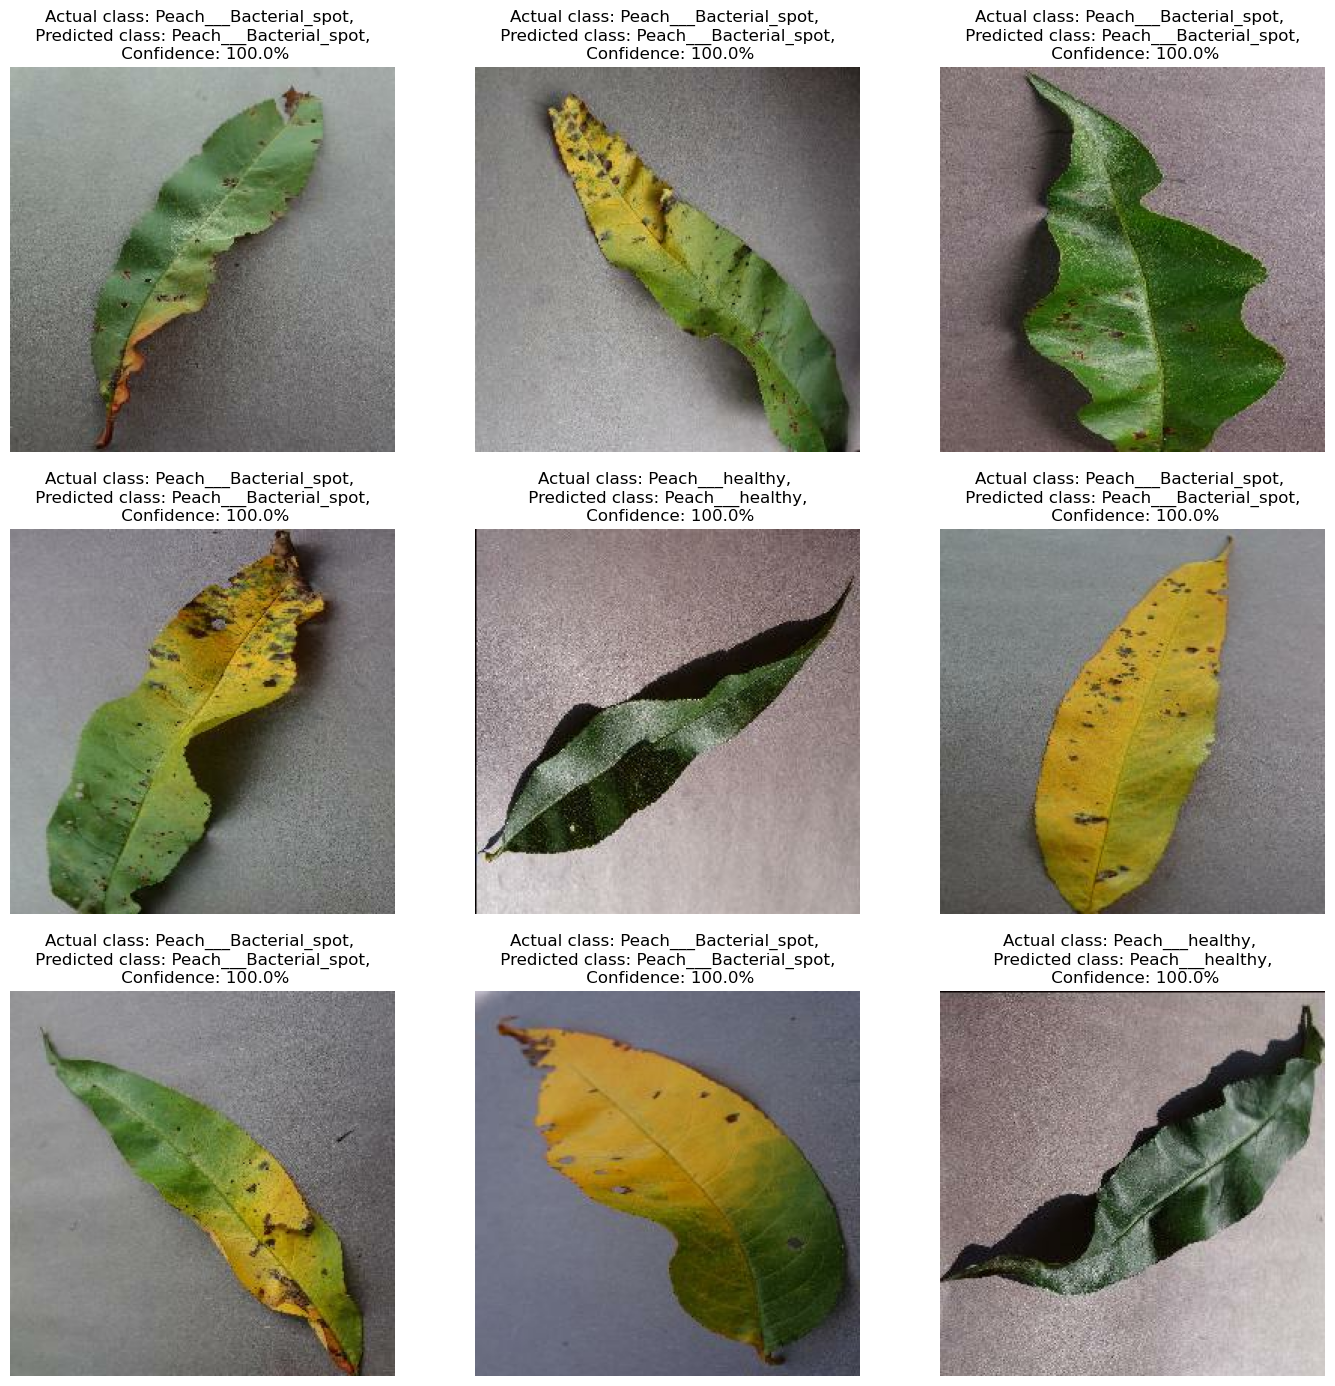

In [28]:
plt.figure(figsize=(17,17))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [29]:
model_version = "Peach_Training_v1"
model.save(f"../Models/{model_version}")



INFO:tensorflow:Assets written to: ../Models/Peach_Training_v1\assets


INFO:tensorflow:Assets written to: ../Models/Peach_Training_v1\assets
